## Price movement from 2:00PM to 2:30PM

In [64]:
# Idea
# Khoang cach(bar) tu cay nen 2h den cay nen cao nhat va thap nhat trong ngay(2 cases: truoc va sau 2h)
# Percent price giua gia luc 2h va gia cao nhat, thap nhat trong ngay
# Su phu thuoc cua return vao 2 yeu to tren

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

In [66]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [67]:
data = dataset.copy()

In [68]:
### Ignore this year data => tranh over fitting
data = data[data.index < '2024-01-01 00:00:00']

In [69]:
def cal_first_close(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 915]
  if not tick.empty:
    return tick[0]


def cal_high_before(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1345]
  return tick.max()


def cal_low_before(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1355]
  return tick.min()

def cal_close(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1425]
  if not tick.empty:
    return tick[0]
      
def cal_last(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1445]
  if not tick.empty:
    return tick[0]

In [70]:
data_tmp = data.copy()
data_tmp['first_close'] = data_tmp.Close
data_tmp['Close_price'] = data_tmp.Close
data_tmp['_last'] = data_tmp.Close
data_tmp['prev_high'] = data_tmp.High
data_tmp['prev_low'] = data_tmp.Low
day_data = data_tmp.resample("D").agg({
    'first_close': cal_first_close,
    'prev_high':cal_high_before,
    'prev_low': cal_low_before,
    'Close_price': cal_close,
    '_last': cal_last
    }).rename(columns={'_last':'day_Close'})
day_data = day_data.dropna()

In [71]:
day_data['prev_day_Close'] = day_data['day_Close'].shift(1)
day_data = day_data.dropna()
day_data

,first_close,prev_high,prev_low,Close_price,day_Close,prev_day_Close
Date,,,,,,
2018-08-15,960.7,962.3,954.7,951.2,946.6,959.3
2018-08-16,942.1,943.5,935.5,944.5,947.0,946.6
2018-08-17,953.2,954.6,946.4,947.0,947.0,947.0
2018-08-20,946.1,951.5,944.1,944.7,945.0,947.0
2018-08-21,945.9,950.8,944.0,954.7,958.5,945.0
...,...,...,...,...,...,...
2023-12-25,1105.3,1117.7,1096.3,1114.9,1115.0,1097.7
2023-12-26,1116.4,1117.2,1113.4,1117.2,1121.5,1115.0
2023-12-27,1121.4,1124.8,1120.4,1118.0,1116.9,1121.5


In [72]:
data = data.assign(time_d=pd.PeriodIndex(data.index, freq='1D').to_timestamp())
data = pd.merge(data, day_data, left_on="time_d", right_index=True, how="left")
data.dropna(inplace=True)

In [73]:
# Drop data before 1:55PM & after 2:10PM
data = data[(100*data.index.hour + data.index.minute > 1350) & (100*data.index.hour + data.index.minute < 1415)]

In [74]:
# mom_y = momentum_yesterday
data['mom_y'] = 100 * (data.Close - data.prev_day_Close) / data.prev_day_Close
data['body_rate'] = (data.Close - data.first_close) / (data.prev_high - data.prev_low)
data['return'] = 1000 * (data.Close_price - data.Close) / data.Close
data.tail(10)

,Open,High,Low,Close,Volume,time_d,first_close,prev_high,prev_low,Close_price,day_Close,prev_day_Close,mom_y,body_rate,return
Date,,,,,,,,,,,,,,,
2023-12-27 14:05:00,1125.3,1125.4,1124.3,1124.4,3720,2023-12-27,1121.4,1124.8,1120.4,1118.0,1116.9,1121.5,0.258582,0.681818,-5.691925
2023-12-27 14:10:00,1124.5,1124.8,1122.8,1122.8,3739,2023-12-27,1121.4,1124.8,1120.4,1118.0,1116.9,1121.5,0.115916,0.318182,-4.275027
2023-12-28 13:55:00,1130.3,1131.7,1130.1,1131.5,3194,2023-12-28,1118.5,1131.8,1117.0,1129.9,1132.9,1116.9,1.307190,0.878378,-1.414052
2023-12-28 14:00:00,1131.5,1131.5,1130.1,1130.7,2906,2023-12-28,1118.5,1131.8,1117.0,1129.9,1132.9,1116.9,1.235563,0.824324,-0.707526
2023-12-28 14:05:00,1130.7,1134.7,1130.0,1133.9,9129,2023-12-28,1118.5,1131.8,1117.0,1129.9,1132.9,1116.9,1.522070,1.040541,-3.527648
2023-12-28 14:10:00,1133.7,1134.1,1132.5,1132.6,3976,2023-12-28,1118.5,1131.8,1117.0,1129.9,1132.9,1116.9,1.405676,0.952703,-2.383895
2023-12-29 13:55:00,1133.0,1133.8,1132.6,1132.8,2862,2023-12-29,1134.5,1139.5,1131.5,1133.9,1134.6,1132.9,-0.008827,-0.212500,0.971045
2023-12-29 14:00:00,1132.8,1133.4,1130.9,1131.9,6188,2023-12-29,1134.5,1139.5,1131.5,1133.9,1134.6,1132.9,-0.088269,-0.325000,1.766941
2023-12-29 14:05:00,1132.0,1134.4,1132.0,1134.3,5158,2023-12-29,1134.5,1139.5,1131.5,1133.9,1134.6,1132.9,0.123577,-0.025000,-0.352640


### Estimated return - distribution

In [75]:
data['return'].describe()

count    5323.000000
mean       -0.233547
std         5.341486
min       -25.493650
25%        -2.548174
50%         0.081639
75%         2.397036
max        29.239766
Name: return, dtype: float64

In [76]:
data['return_group'] = pd.cut(data['return'], 30)
r1 = data.groupby(['return_group'])[['return']].count()
r11 = r1[['return']].rename(columns={'return': 'count'})
r11

,count
return_group,
"(-25.548, -23.669]",5
"(-23.669, -21.845]",7
"(-21.845, -20.02]",9
"(-20.02, -18.196]",14
"(-18.196, -16.371]",16
"(-16.371, -14.547]",30
"(-14.547, -12.723]",50
"(-12.723, -10.898]",64
"(-10.898, -9.074]",83


In [77]:
# Think about drop the outlier data
data = data[(data['return'] > -20) & (data['return'] < 15)]

### Body rate - distribution

In [78]:
data['body_rate'].describe()

count    5258.000000
mean        0.006456
std         0.614608
min        -2.244898
25%        -0.485258
50%         0.014087
75%         0.485645
max         2.888000
Name: body_rate, dtype: float64

In [79]:
data['body_rate_group'] = pd.qcut(data.body_rate, 30)

### Momentum today-yesterday - distribution

In [80]:
data['mom_y'].describe()

count    5258.000000
mean        0.047983
std         1.315756
min       -10.462963
25%        -0.417971
50%         0.071460
75%         0.602858
max        10.799805
Name: mom_y, dtype: float64

In [81]:
data['mom_y_group'] = pd.qcut(data.mom_y, 20)

### Regplot

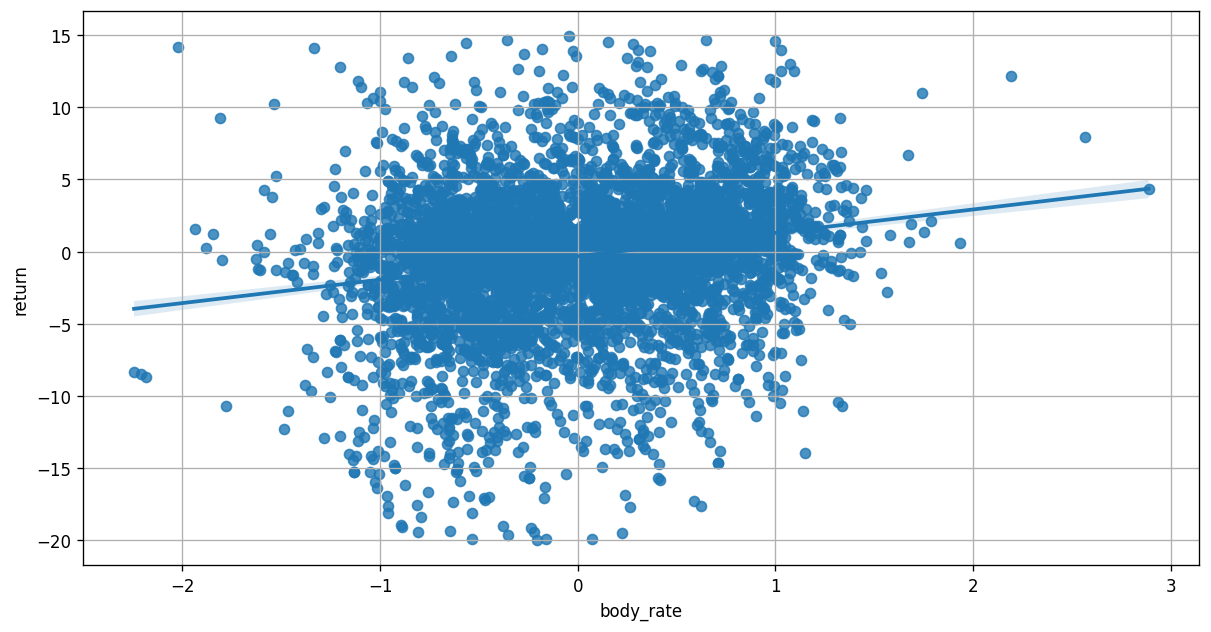

In [82]:
sns.regplot(x=data['body_rate'], y=data['return'])
plt.grid(True)

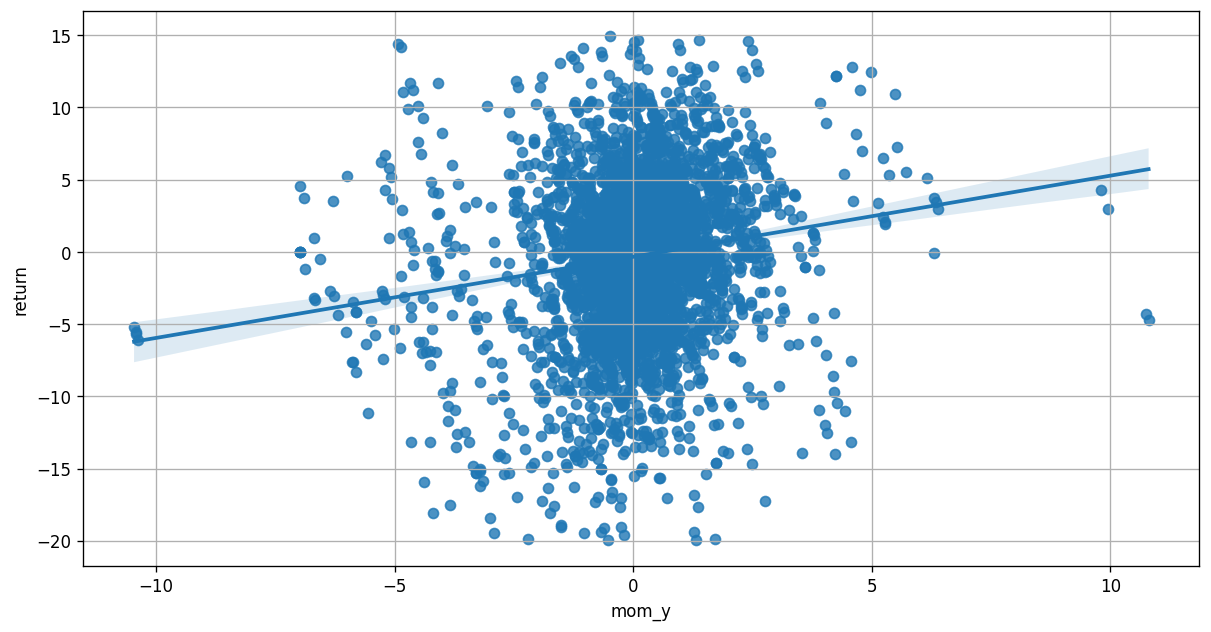

In [83]:
sns.regplot(x=data['mom_y'], y=data['return'])
plt.grid(True)

### Heatmap

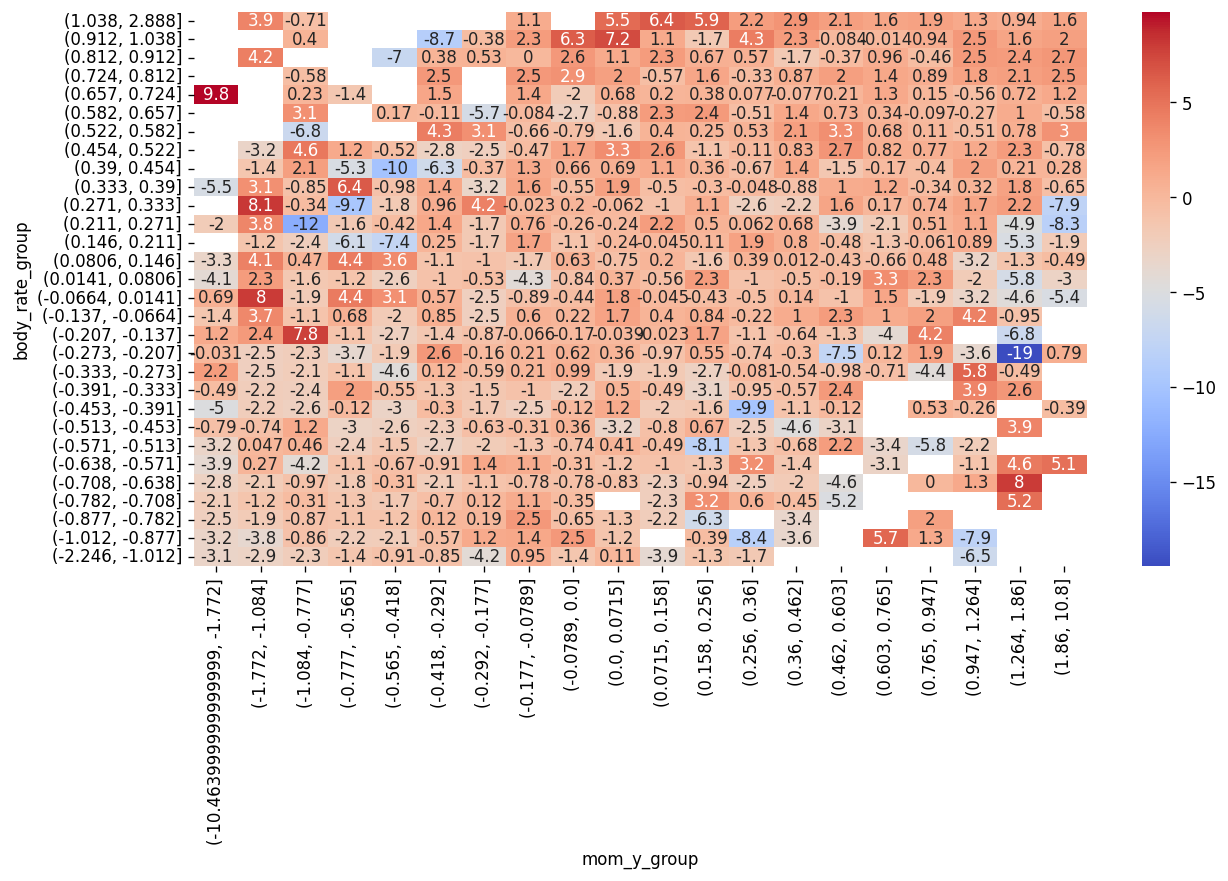

In [84]:
grpd = data.groupby(['body_rate_group', 'mom_y_group'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='body_rate_group', columns='mom_y_group', values='return').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);